# SGSIM User Guide

Welcome to this interactive tutorial for getting started with SGSIM, a Python library for stochastic ground motion simulation! This Jupyter Notebook will guide you through the key steps to:
- Load a target real earthquake motion.
- Build and calibrate a stochastic model.
- Simulate synthetic ground motions.
- Visualize and analyze the results.

Each section includes explanations and executable code cells. Feel free to modify parameters (like file paths or simulation counts) to experiment as you go. Let’s dive in!

**Prerequisites**: Ensure you have `sgsim` installed and an accelerogram file (e.g., `Northridge.AT2`) ready.

## Step 1: Import Libraries and Load Real Motion

First, we’ll import the necessary `sgsim` components and load a real earthquake motion from a file. This motion will serve as the target for our stochastic model.

- Replace the `file_path` with the location of your `.AT2` file (e.g., from the PEER NGA database).
- The `source` parameter specifies the file format (`'nga'` for NGA-style files, etc.).
- We’ll trim the motion to focus on the specified energy range (0.1% to 99.9%) to avoid flat tails.

In [3]:
import time
from sgsim import StochasticModel, Motion, calibrate, ModelPlot, functions, tools

# Update this path to your accelerogram file
file_path = r'C:\path\to\Northridge.AT2'  # Example: r"C:\Users\Me\Documents\Northridge.AT2"
file_path = r"c:\Users\Sajad\OneDrive - Universidade do Minho\Python-Scripts\test_code\N1.AT2"
source = 'nga'

# Load and prepare the real motion
real_motion = Motion.from_file(file_path, source)
real_motion.set_range(option='energy', range_slice=(0.001, 0.999))

# Optional: Uncomment to apply a bandpass filter (e.g., 0.1–25 Hz)
# real_motion.filter(bandpass_freqs=(0.1, 25.0))

print("Real motion loaded with", real_motion.npts, "points and a time step of", real_motion.dt, "seconds.")

Real motion loaded with 1575 points and a time step of 0.02 seconds.


## Step 2: Initialize the Stochastic Model

Next, we’ll create a stochastic model to match the real motion. SGSIM uses parameters like:
- `npts` and `dt`: Match the real motion’s time series properties.
- `modulating`: Defines temporal non-stationarity and energy content (e.g., `beta_dual` for two strong phases).
- `upper_frequency`, `upper_damping`, `lower_frequency`, and `lower_damping` defines spectral non-stationarity and frequency content 
- Frequency and damping functions: Set to `linear` here, but you can explore `exponential`.

This model will generate synthetic motions based on these settings.

In [4]:
# Initialize the stochastic model
model = StochasticModel(npts=real_motion.npts, dt=real_motion.dt, 
                        modulating=functions.beta_dual,
                        upper_frequency=functions.linear, upper_damping=functions.linear,
                        lower_frequency=functions.linear, lower_damping=functions.linear)

print("Stochastic model initialized with", model.npts, "points.")

Stochastic model initialized with 1575 points.


## Step 3: Calibrate the Model

Now, we’ll calibrate the model to match the real motion’s characteristics. Calibration adjusts:
- Modulation (envelope).
- Frequency and damping parameters.

We’ll use a sequential scheme (`modulating`, `frequency`, `damping`) and time the process. Note the order of calibration.

In [5]:
start = time.perf_counter()
scheme = ['modulating', 'frequency', 'damping']
for func in scheme:
    calibrate(func, model, real_motion, initial_guess=None, lower_bounds=None, upper_bounds=None)

end = time.perf_counter()
print(f"\nModel calibration completed in {end - start:.1f} seconds.")


Model calibration completed in 0.1 seconds.


## Step 4: Simulate Ground Motions

With the model calibrated, we’ll simulate synthetic ground motions. You can:
- View the calibrated parameters with `show_parameters()`.
- Save them to a file (update the path as needed).
- Generate `n` simulations (try changing `n` to 10 or 50!).

Simulated data (acceleration, velocity, etc.) will be stored in `model.ac`, `model.vel`, etc.

In [6]:
# Display calibrated parameters
model.show_parameters()

# Optional: Save parameters (update the path)
# model.save_parameters(filename=r"C:\path\to\model_params.txt")
model.save_parameters(filename=r"C:\Users\Sajad\OneDrive - Universidade do Minho\Python-Scripts\test_code\model_params.txt")

# Simulate 25 ground motions (adjust n as desired)
model.simulate(n=25)

print(f"Simulated {model.ac.shape[0]} motions.")


modulating_func (mdl): beta_dual 0.19275608467011104, 24.374776706208866, 0.19275608467170274, 1.0000000002251053, 0.740027384854044, 25039.378354291694, 31.48
upper_frequency_func (wu): linear 6.172523365181647, 0.594109305811042
lower_frequency_func (wl): linear 0.7489765140610086, 0.20017748302661698
upper_damping_func (zu): linear 0.6828893067934746, 0.10000000000161098
lower_damping_func (zl): linear 1.013752217782404, 0.3081754865637236
Simulated 25 motions.


## Step 5: Analyze Simulated Motions

We’ll create a `Motion` object from the simulations to access properties like Fourier spectra (`fas`) or response spectra (`sa`). You can also save results as columns to CSV files (update the paths to your preferred locations).

In [7]:
# Create simulated motion object
sim_motion = Motion.from_model(model)

# Optional: Save simulation results (update paths)
# sim_motion.save_simulations(filename=r"C:\path\to\simulated_spectra.csv", x_var="tp", y_vars=["sa", "sv", "sd"])
# sim_motion.save_simulations(filename=r"C:\path\to\simulated_motions.csv", x_var="t", y_vars=["ac", "vel", "disp"])
sim_motion.save_simulations(filename=r"C:\Users\Sajad\OneDrive - Universidade do Minho\Python-Scripts\test_code\simulated_spectra.csv", x_var="tp", y_vars=["sa", "sv", "sd"])
sim_motion.save_simulations(filename=r"C:\Users\Sajad\OneDrive - Universidade do Minho\Python-Scripts\test_code\simulated_motions.csv", x_var="t", y_vars=["ac", "vel", "disp"])

print("Simulated motion object created. Access properties like sim_motion.sa or sim_motion.fas.")

Simulated motion object created. Access properties like sim_motion.sa or sim_motion.fas.


## Step 6: Plot Results

Finally, let’s visualize the results using `ModelPlot`. This compares real and simulated motions with:
- Time series (acceleration, velocity, displacement).
- Cumulative energy, Fourier spectra, and response spectra.
- Error metrics (e.g., `mzc`, `mle`).

Plots will display inline below each cell. Adjust `config` (e.g., add `'figsize': (10, 6)`) for customization.

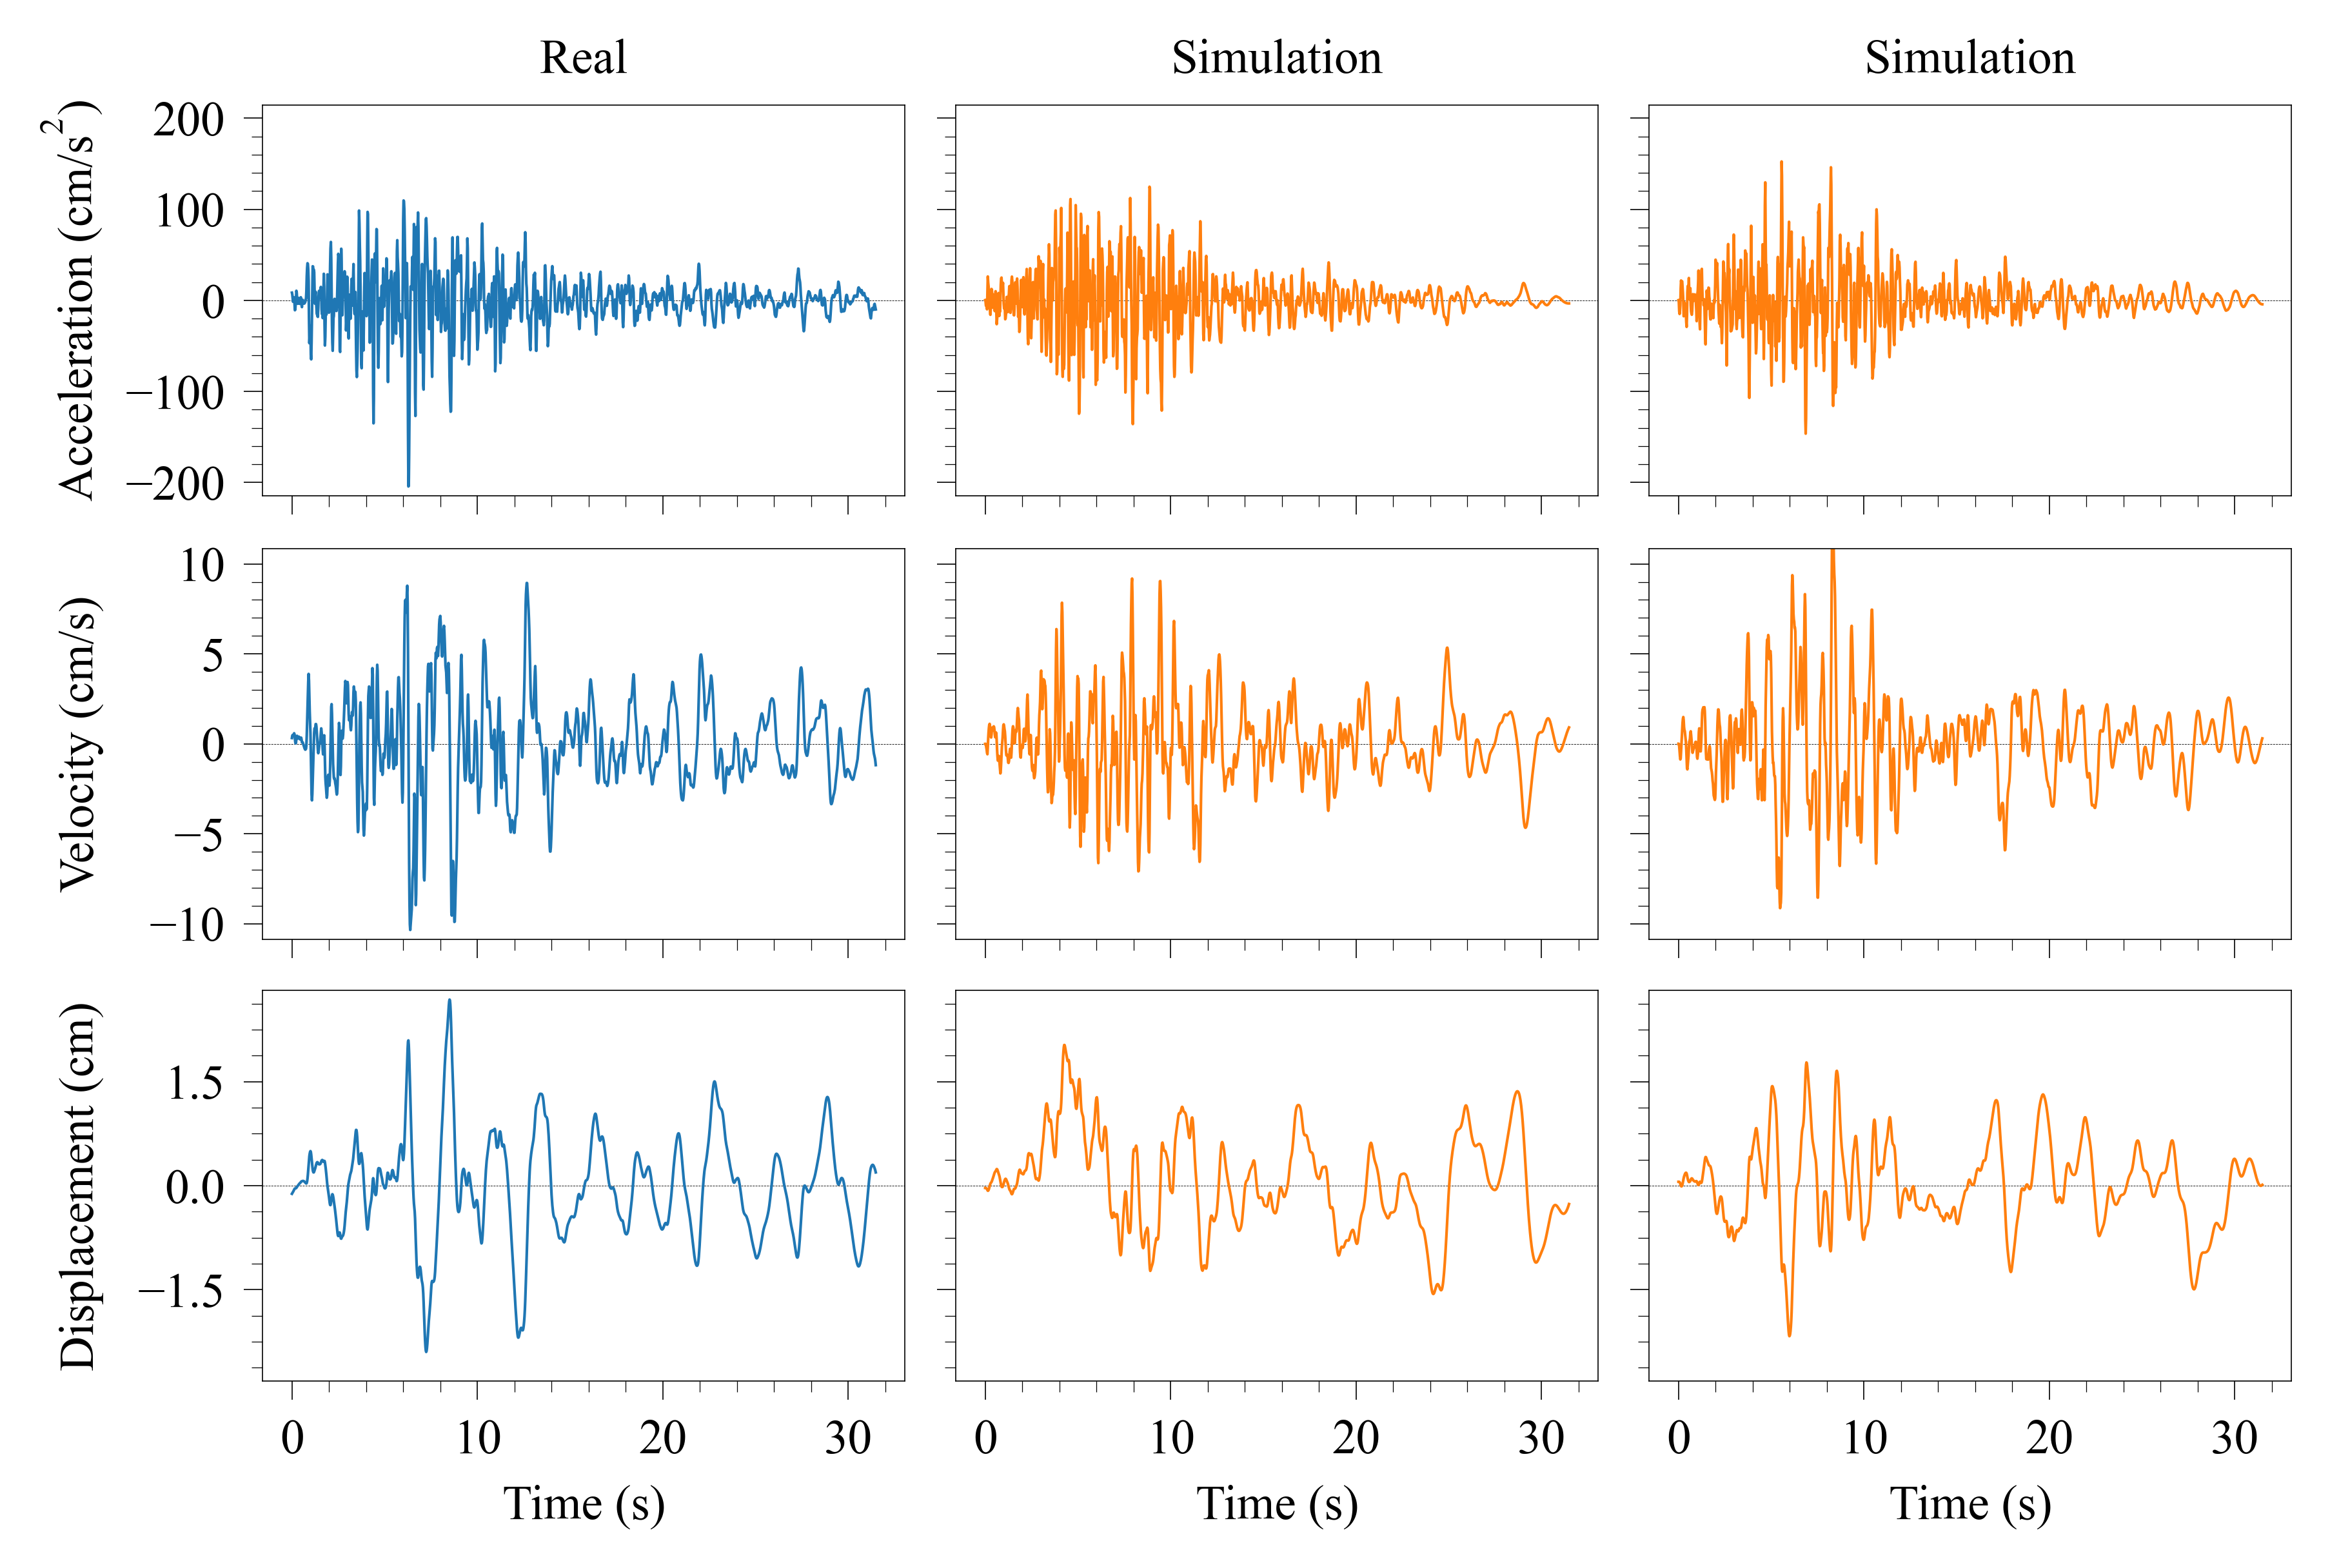

In [8]:
# Initialize plotting tool
mp = ModelPlot(model, sim_motion, real_motion)
config = {'figure.dpi': 600}

# Plot time series
mp.plot_motions(0, -1, config=config)  # Shows inline

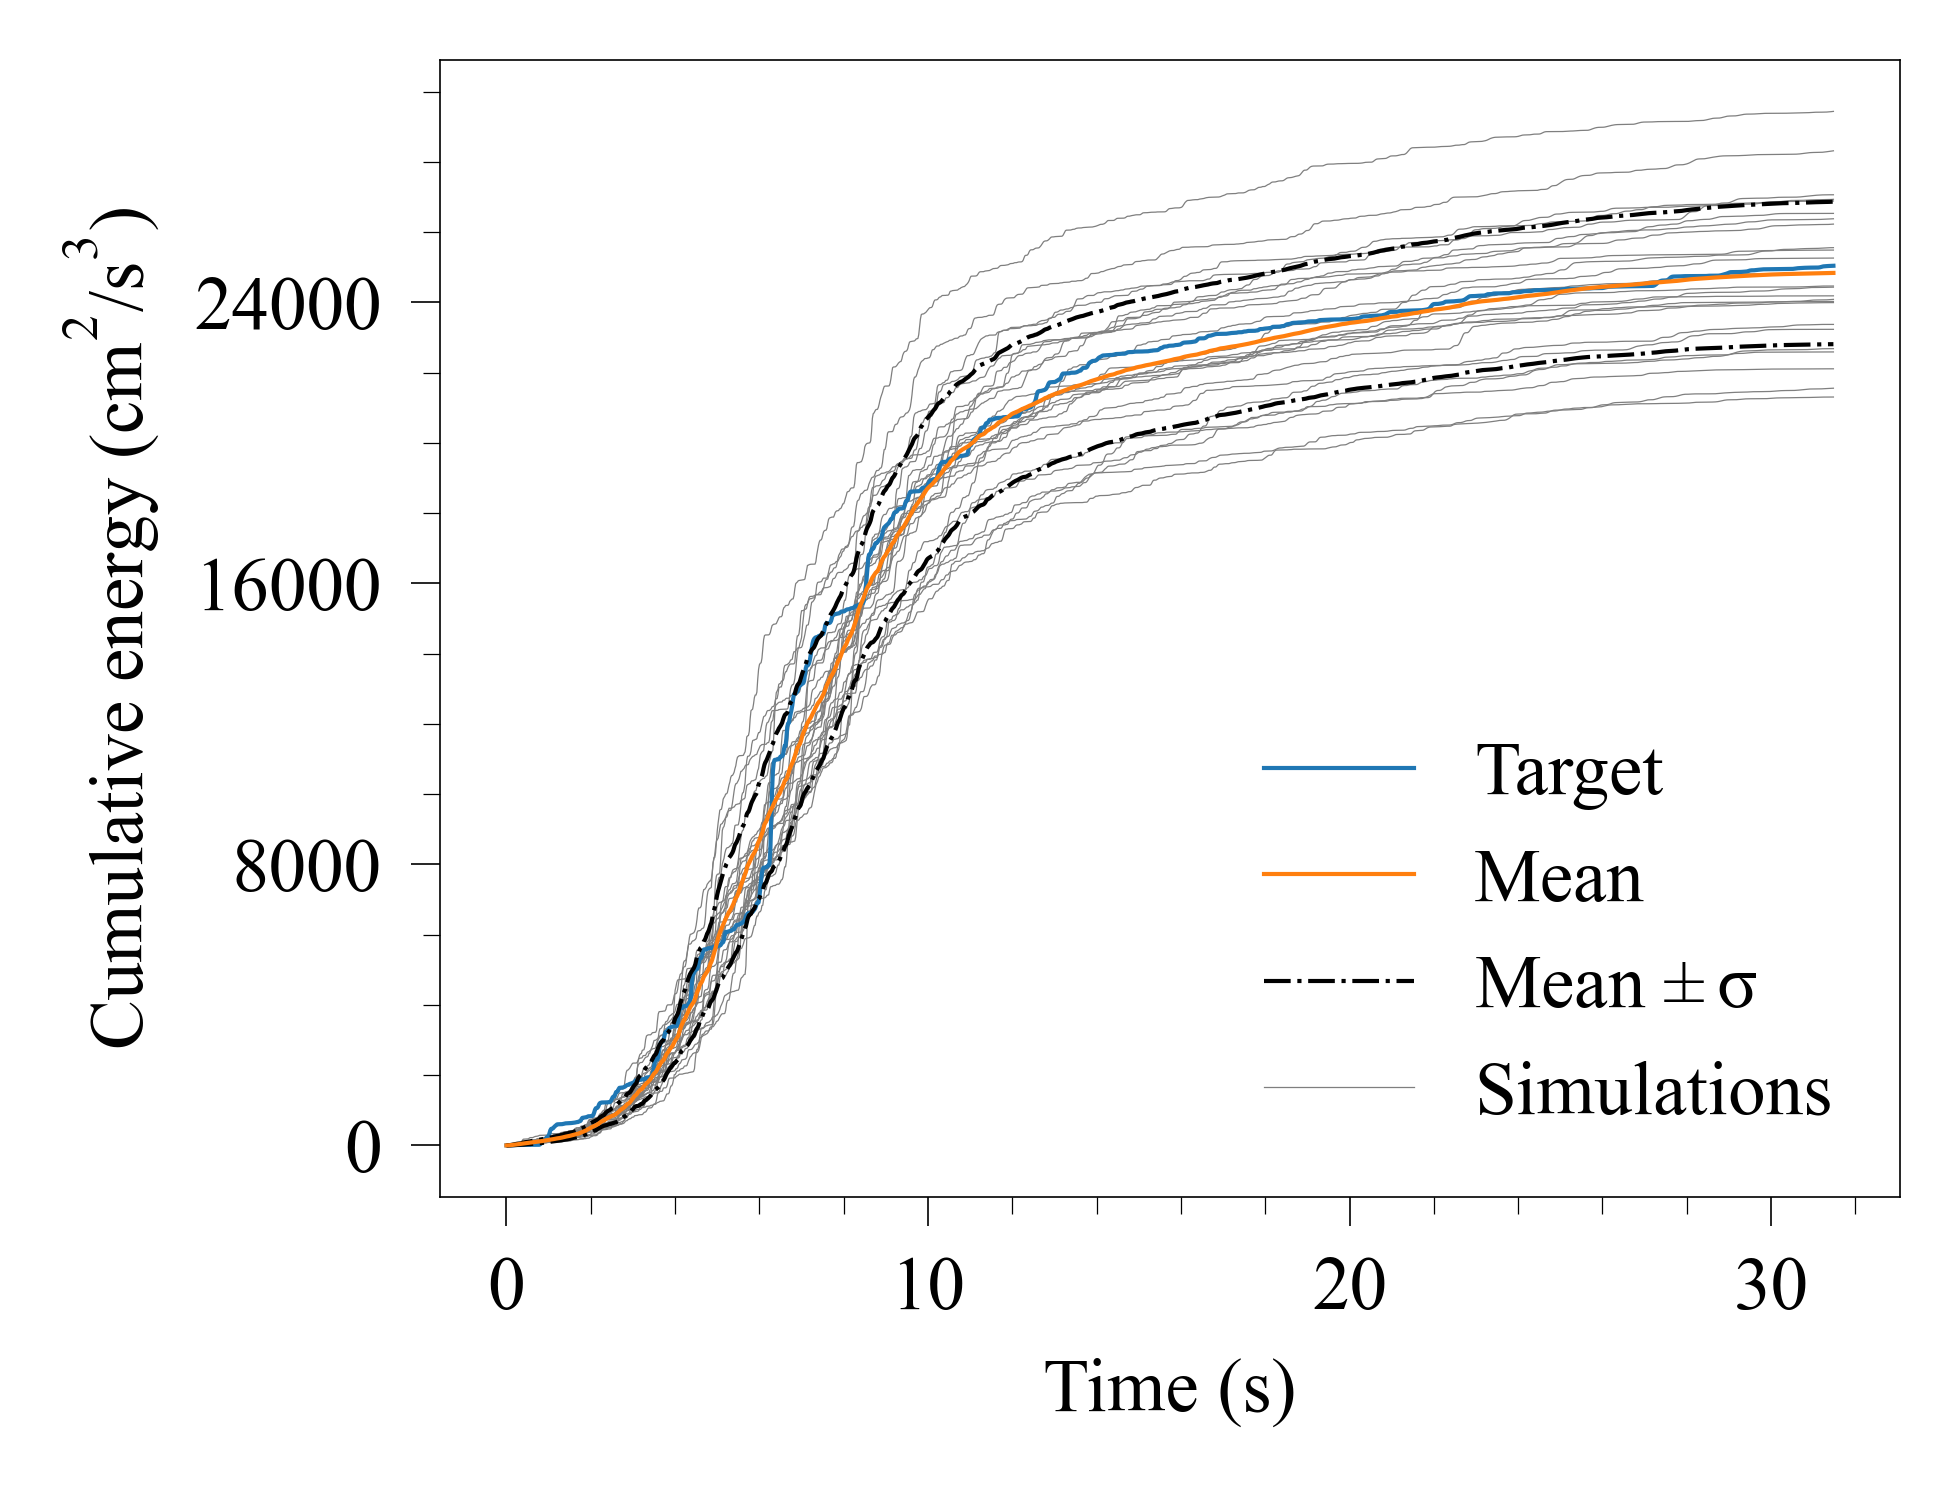

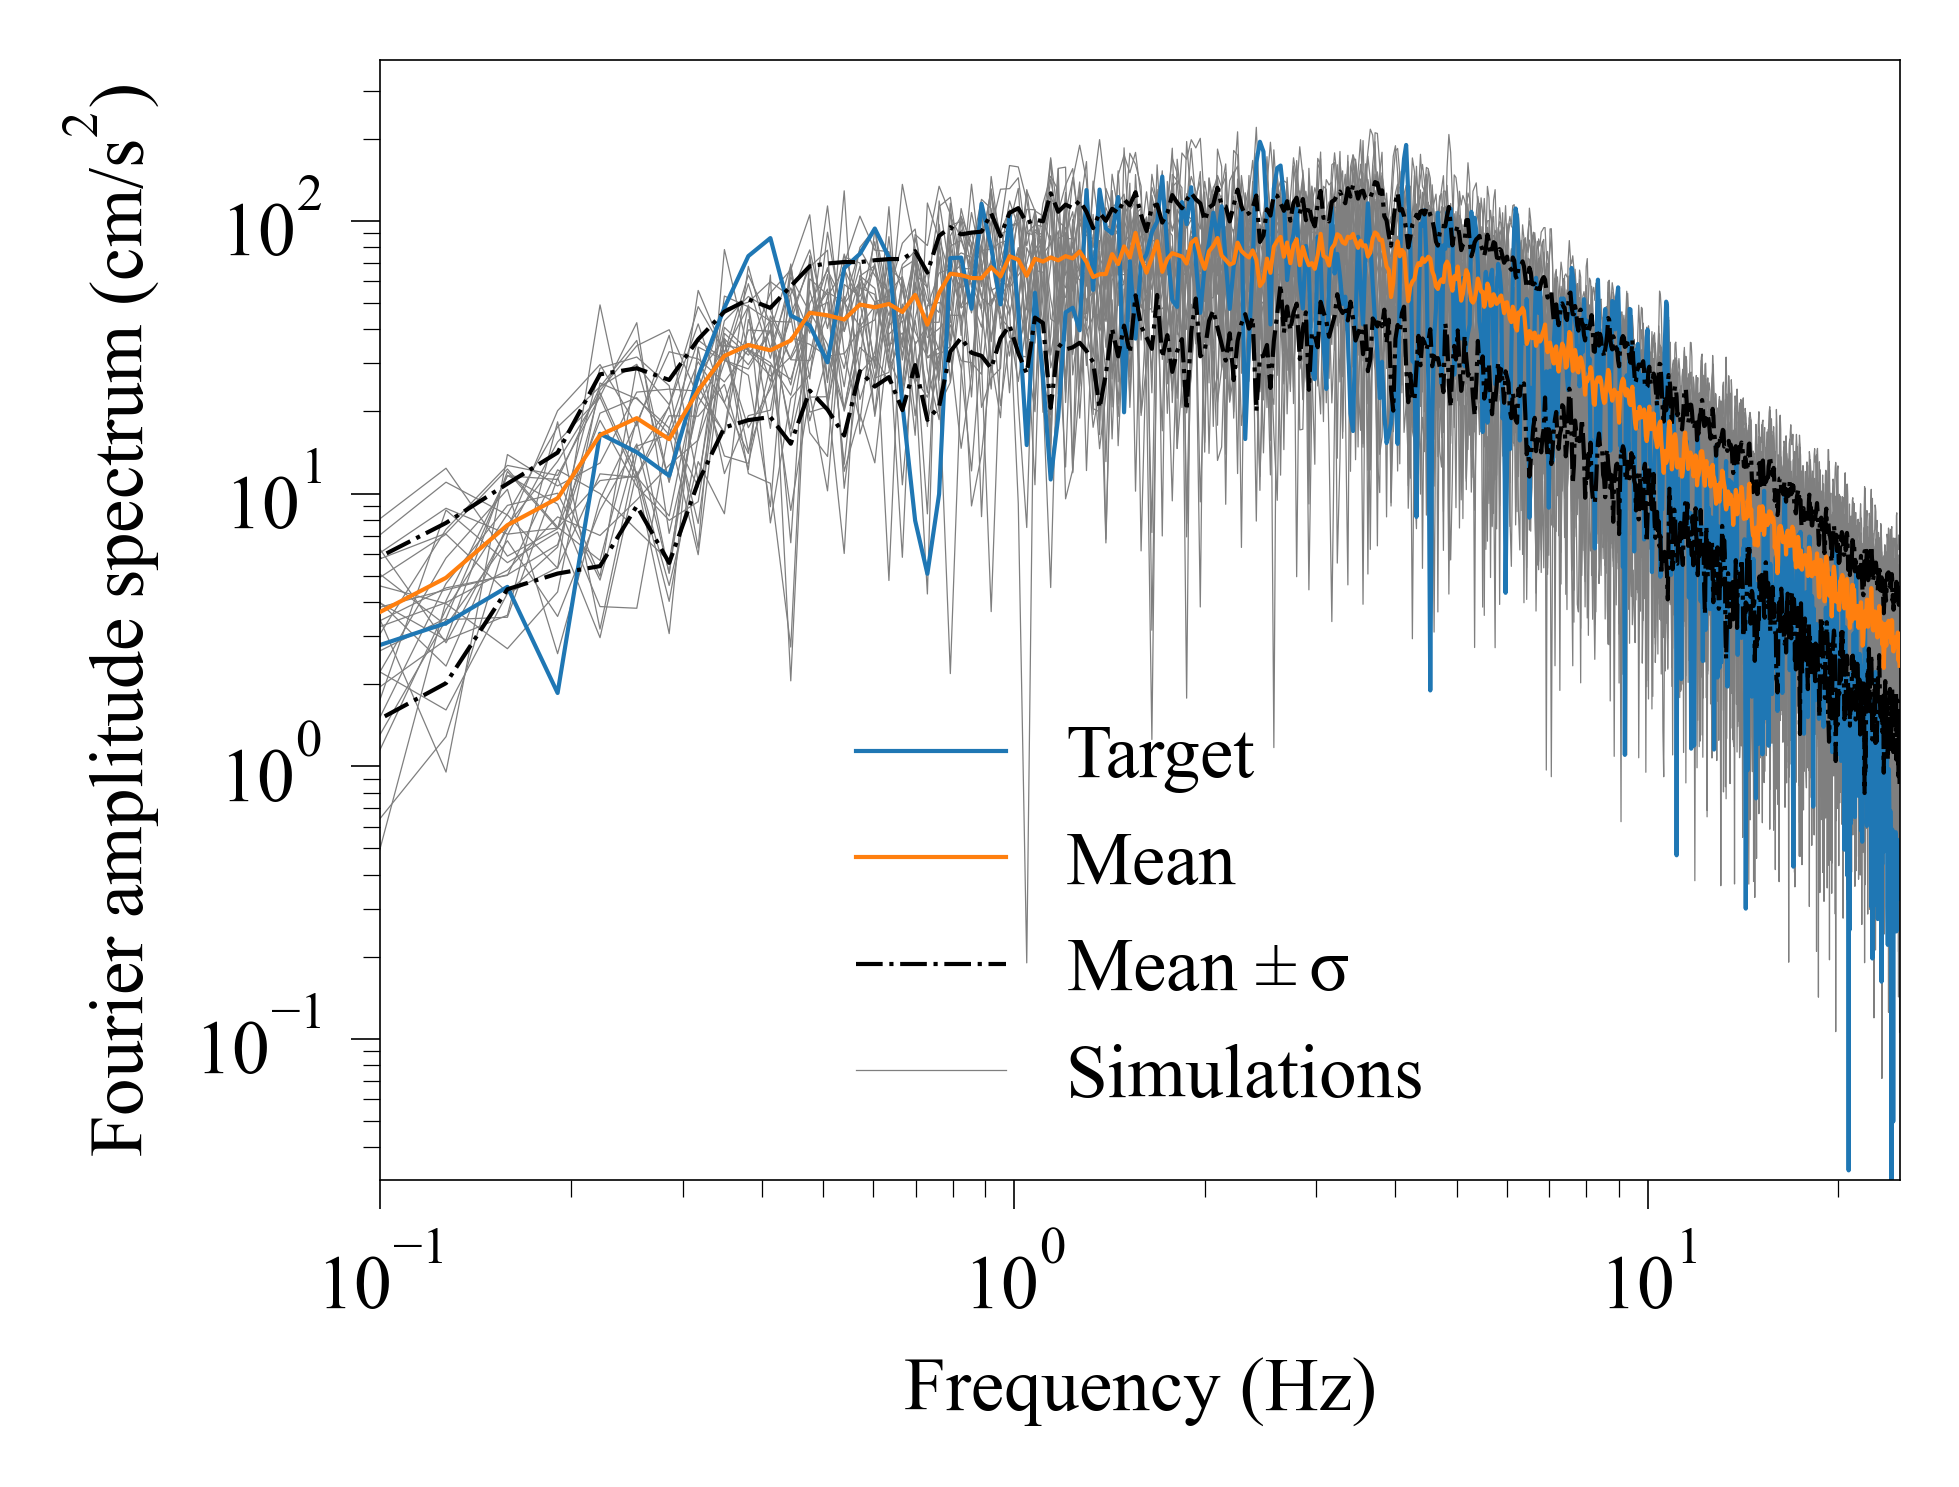

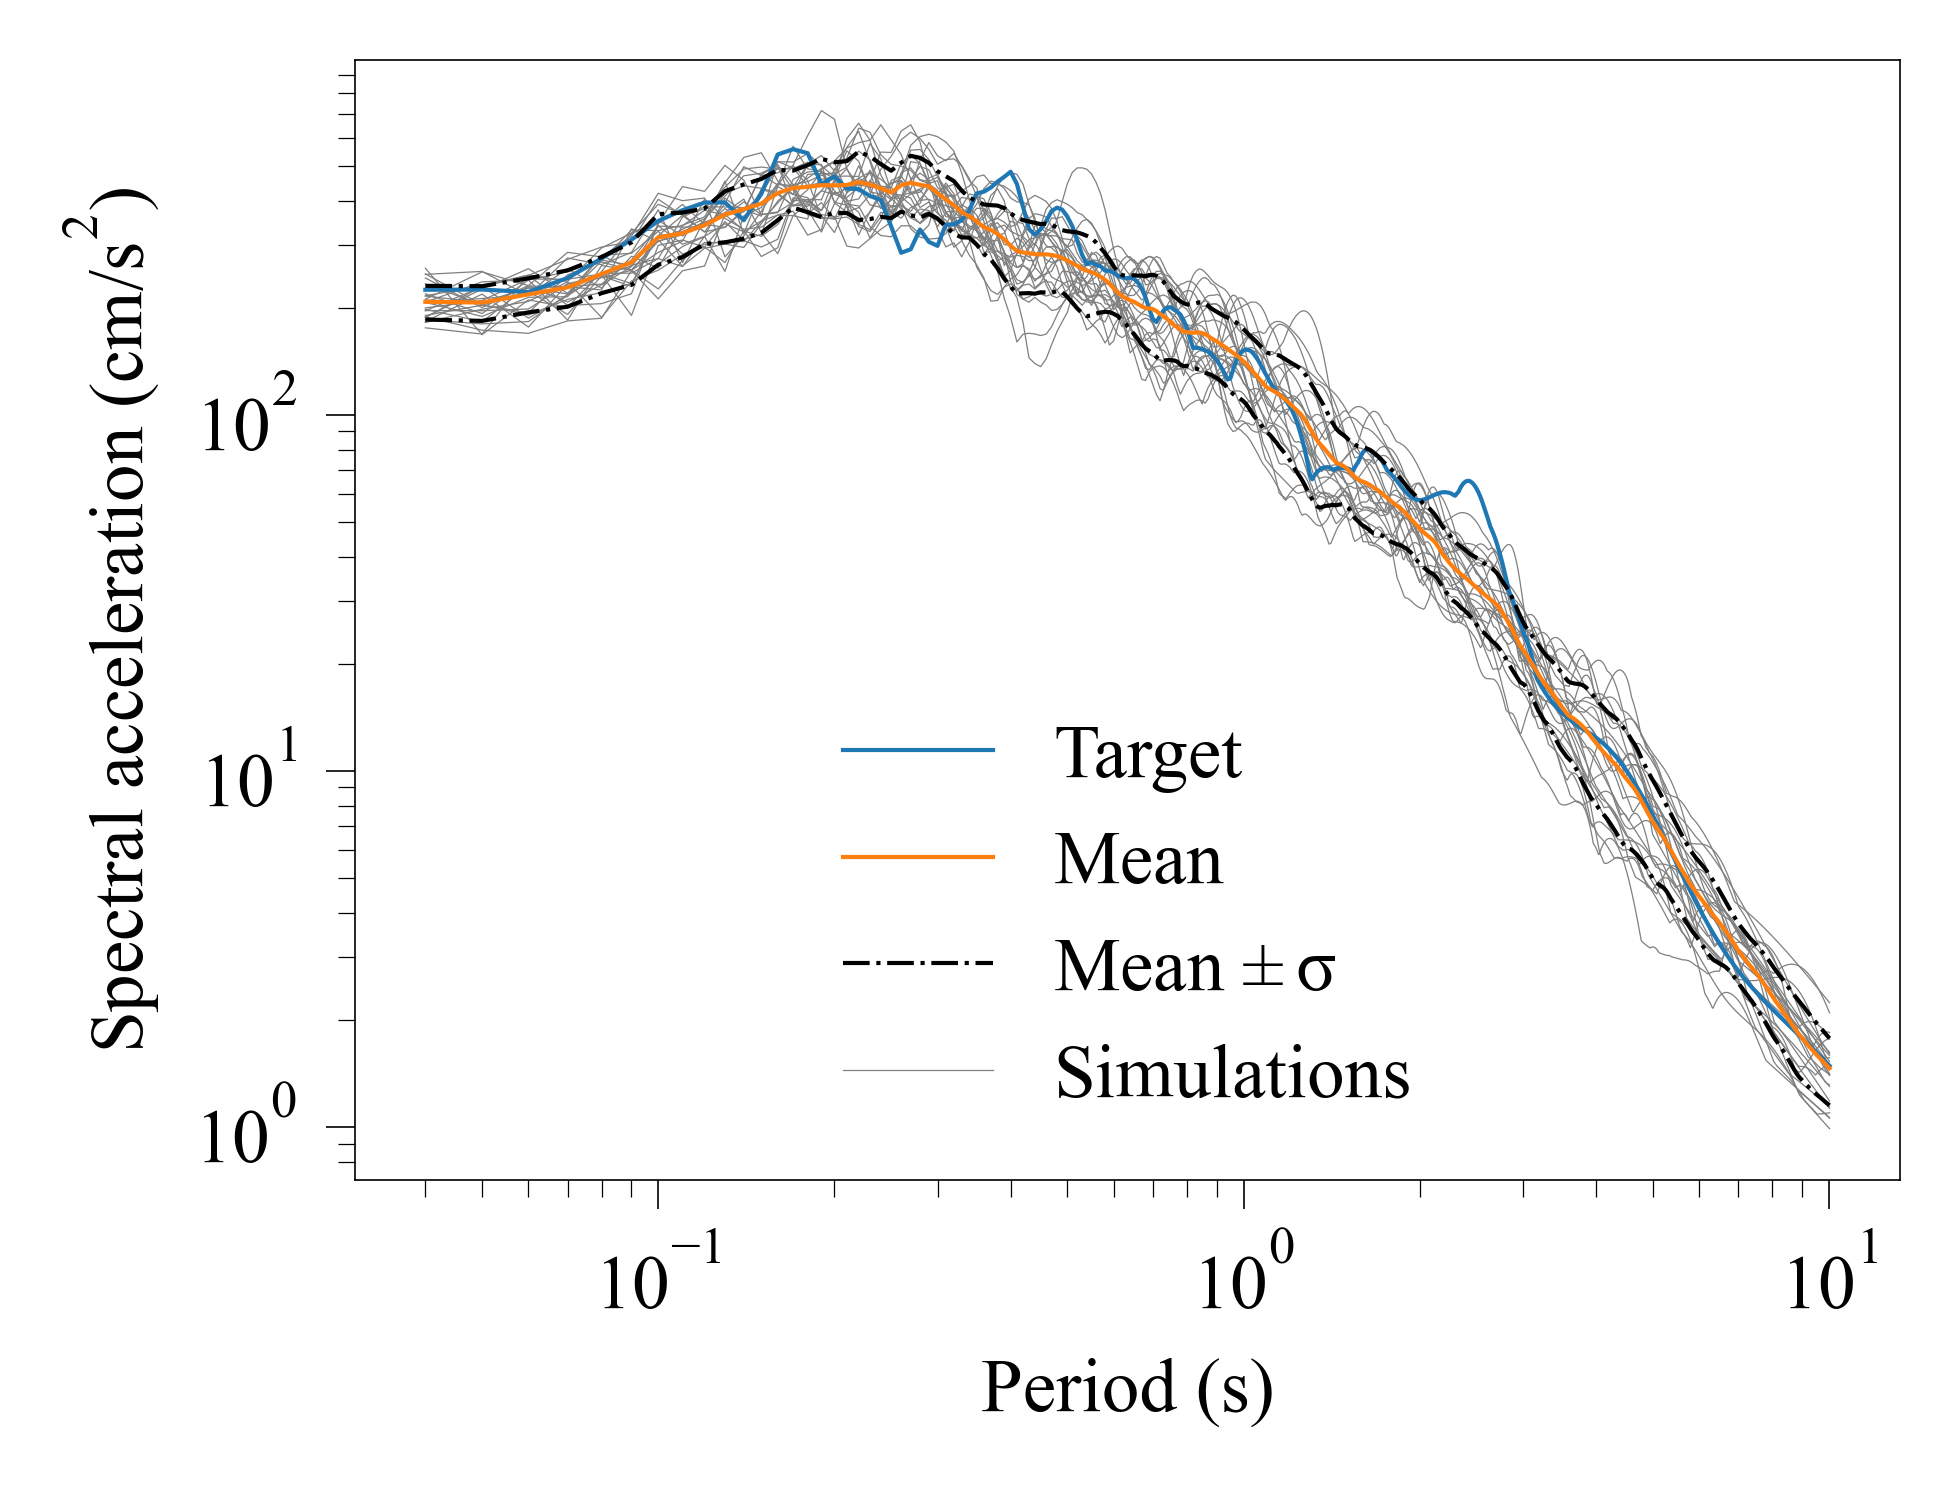

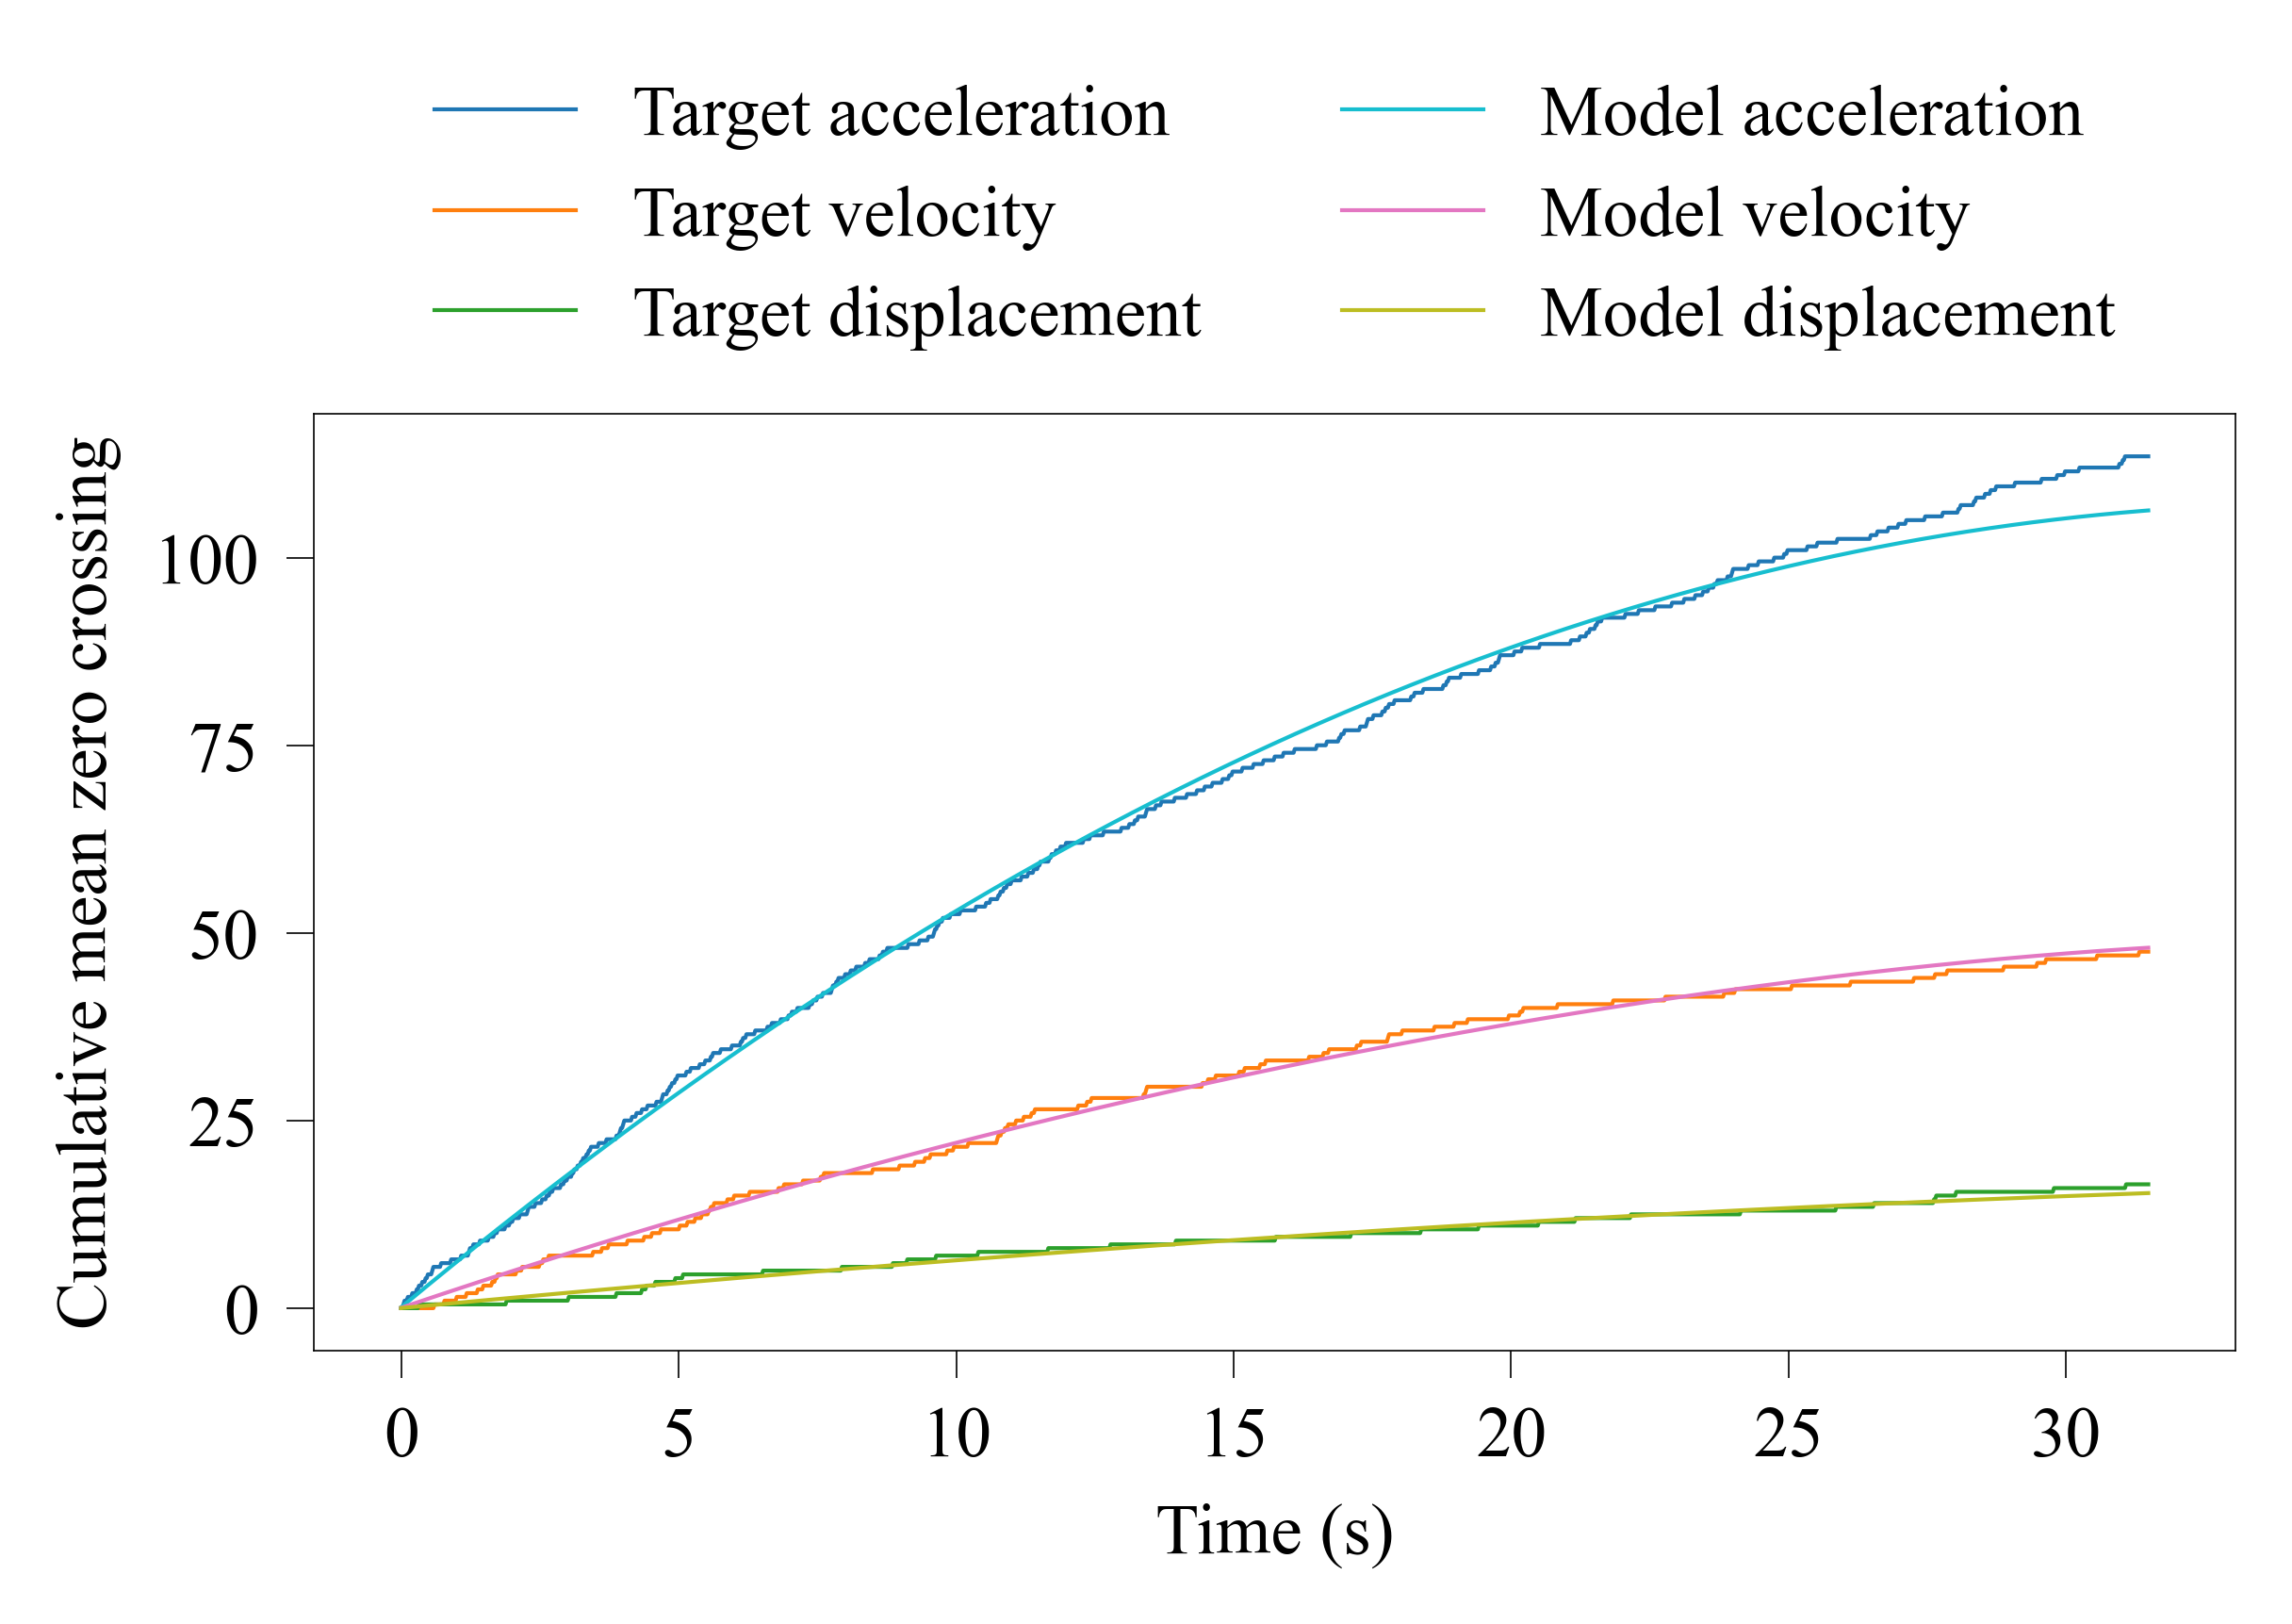

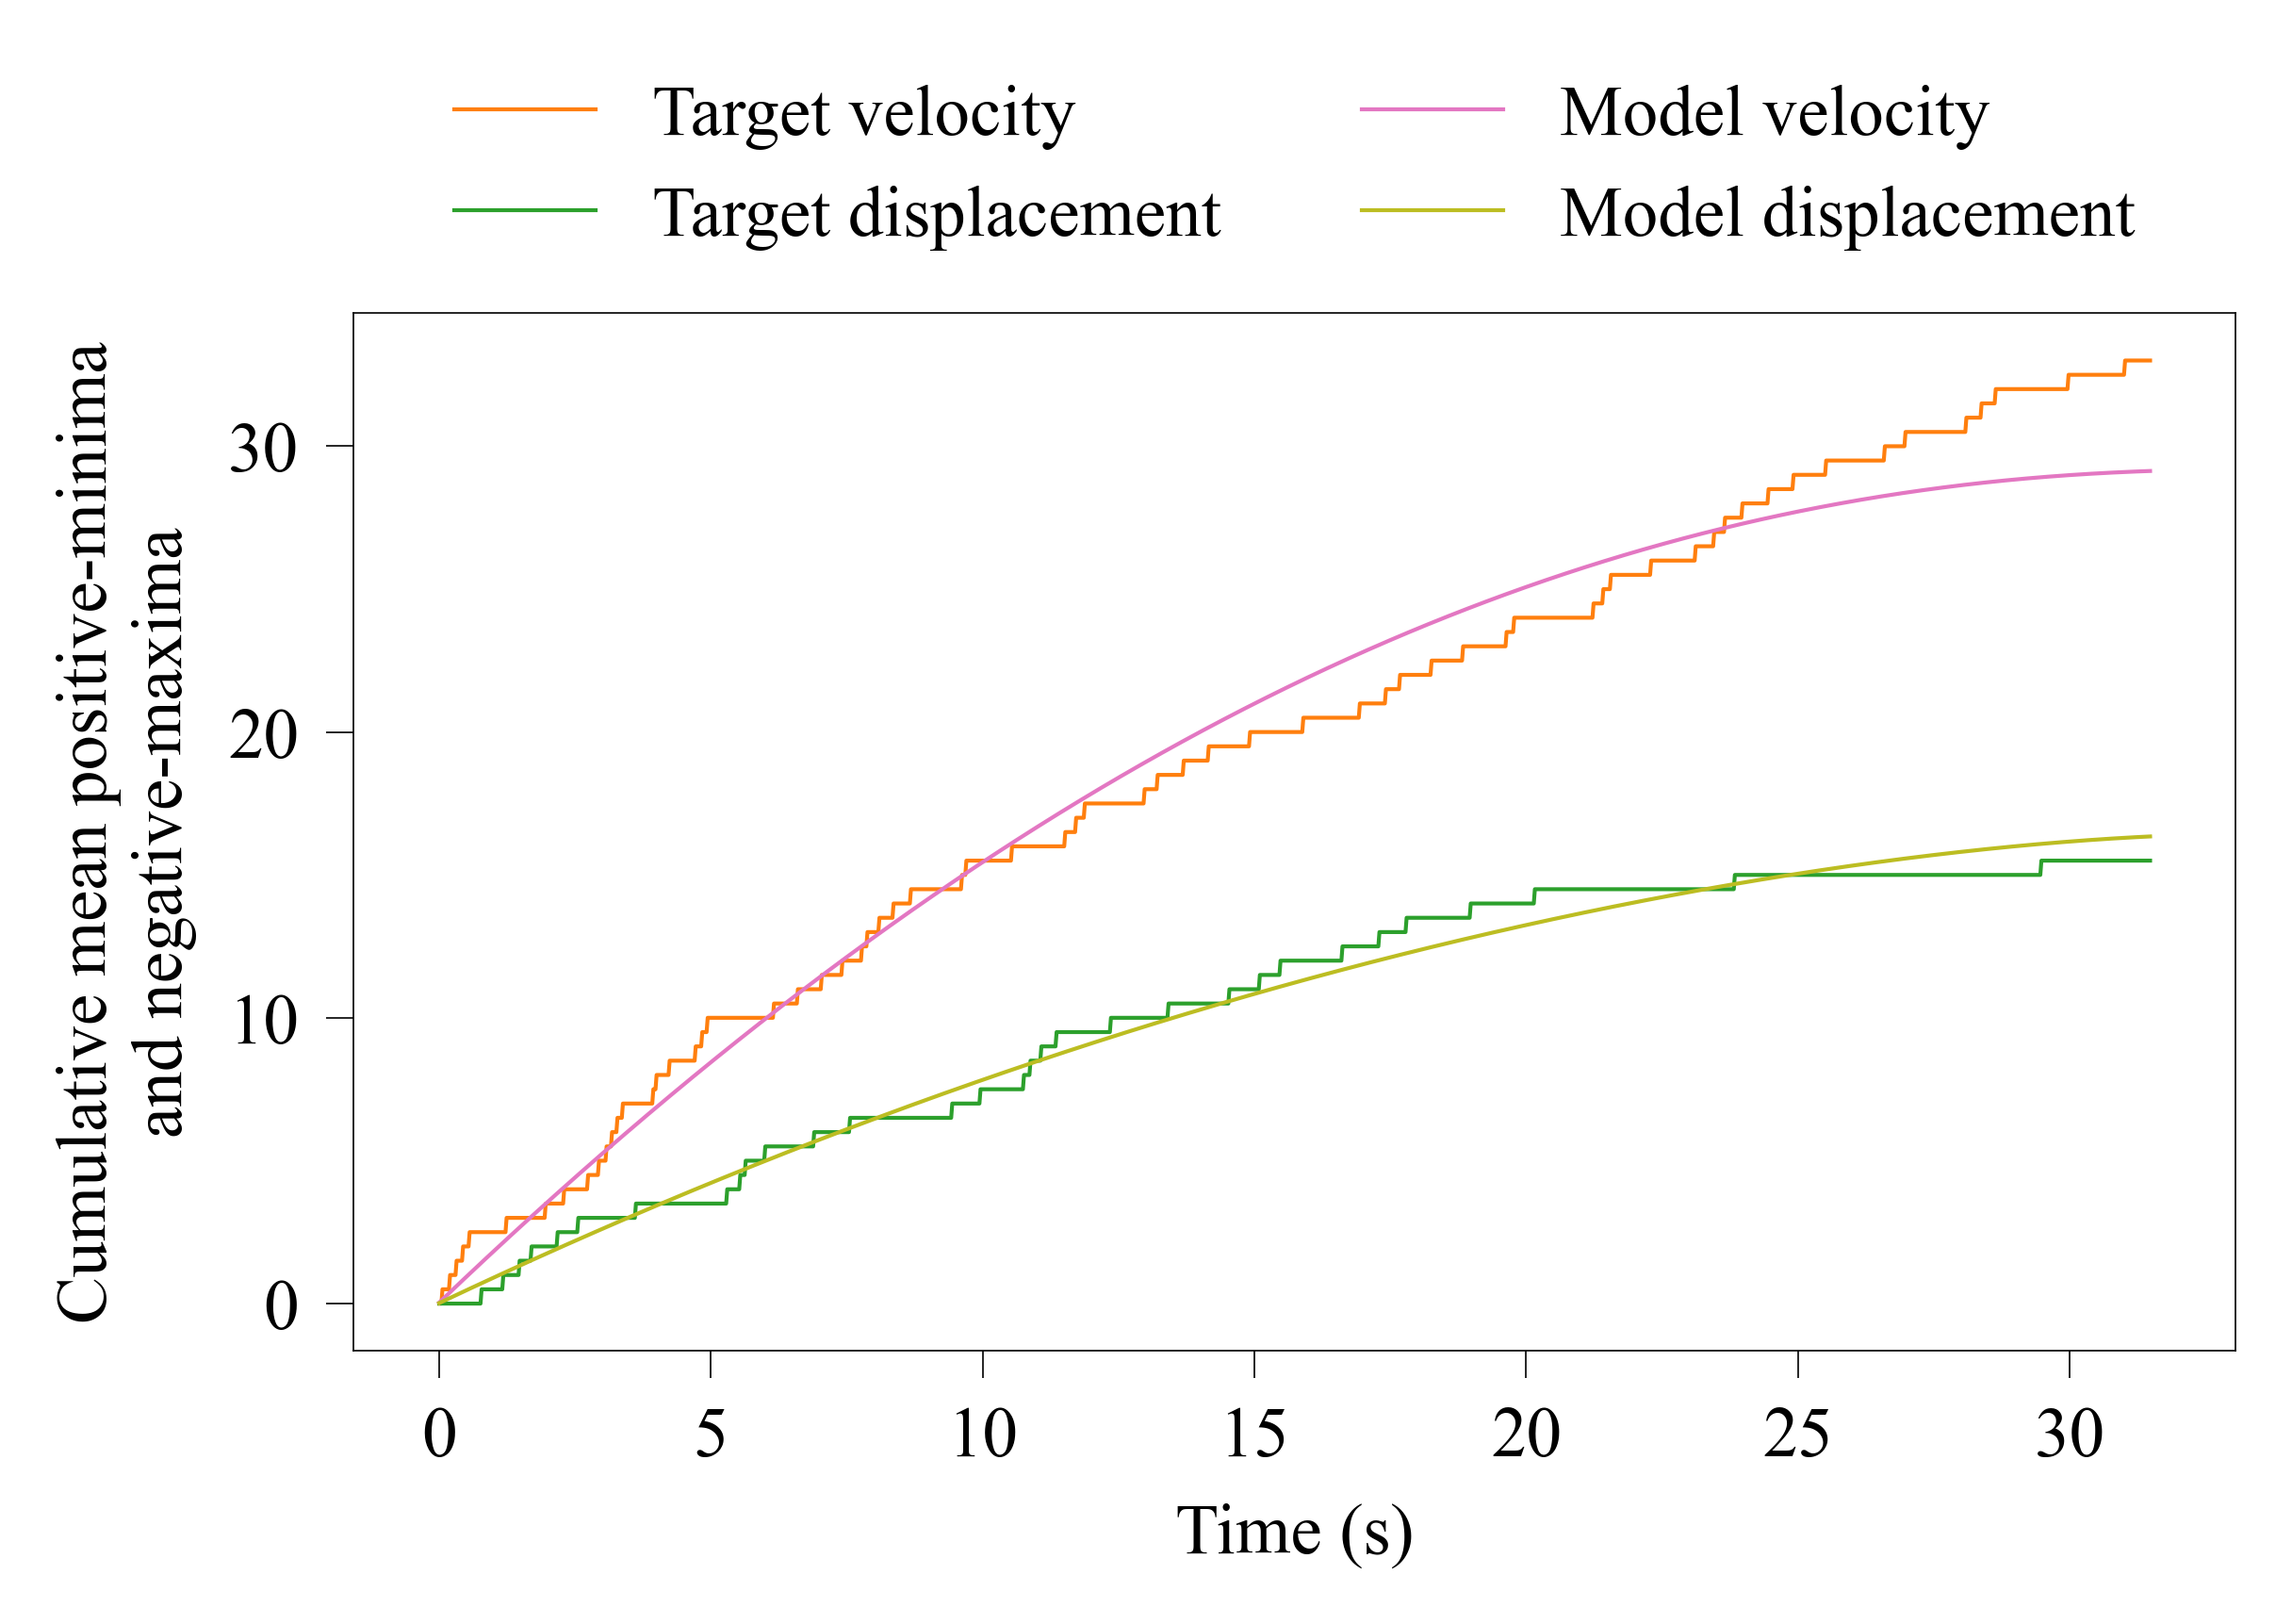

In [9]:
# Plot additional metrics
mp.plot_ce(config=config)  # Cumulative energy
mp.plot_fas(config=config)  # Fourier amplitude spectrum
mp.plot_spectra(spectrum='sa', config=config)  # Response spectrum (Sa)
mp.plot_feature(feature='mzc', config=config)  # Mean zero-crossing rate
mp.plot_feature(feature='pmnm', config=config)  # Mean zero-crossing rate

## Wrap-Up

You’ve now loaded a real motion, calibrated a stochastic model, simulated synthetic ground motions, and visualized the results—all within this notebook! Experiment by:
- Changing the input file or number of simulations.
- Tweaking plot configurations.
- Exploring other SGSIM features.

Save this notebook to keep your work!